In [65]:
import sys
sys.path.append('../bgrl')
from transforms import DropEdges, DropEdgesWeighted
from torch_geometric.datasets import KarateClub, Planetoid
import networkx as nx
from networkx.algorithms.centrality import (
    betweenness_centrality, 
    degree_centrality
)
from torch_geometric.utils import to_networkx
import torch
import pickle as pkl
from copy import deepcopy

In [66]:
data = KarateClub()[0]
data

Data(x=[34, 34], edge_index=[2, 156], y=[34], train_mask=[34])

In [67]:
data_dropped = DropEdges(0.5)(deepcopy(data))
data_dropped

Data(x=[34, 34], edge_index=[2, 76], y=[34], train_mask=[34], edge_attr=[156])

In [68]:
def log_normalize(d):
    arr = torch.tensor([v for k, v in sorted(d.items())])
    mn = min(arr)
    mx = max(arr)
    arr = (arr-mn)/(mx-mn)
    return arr

In [69]:
G = to_networkx(data, to_undirected=True)
data.centrality = log_normalize(betweenness_centrality(G))
data_dropped_weighted = DropEdgesWeighted(0.5)(deepcopy(data))

In [70]:
print(data)
print(data_dropped)
print(data_dropped_weighted)

Data(x=[34, 34], edge_index=[2, 156], y=[34], train_mask=[34], centrality=[34])
Data(x=[34, 34], edge_index=[2, 76], y=[34], train_mask=[34], edge_attr=[156])
Data(x=[34, 34], edge_index=[2, 78], y=[34], train_mask=[34], centrality=[34], edge_attr=[156])


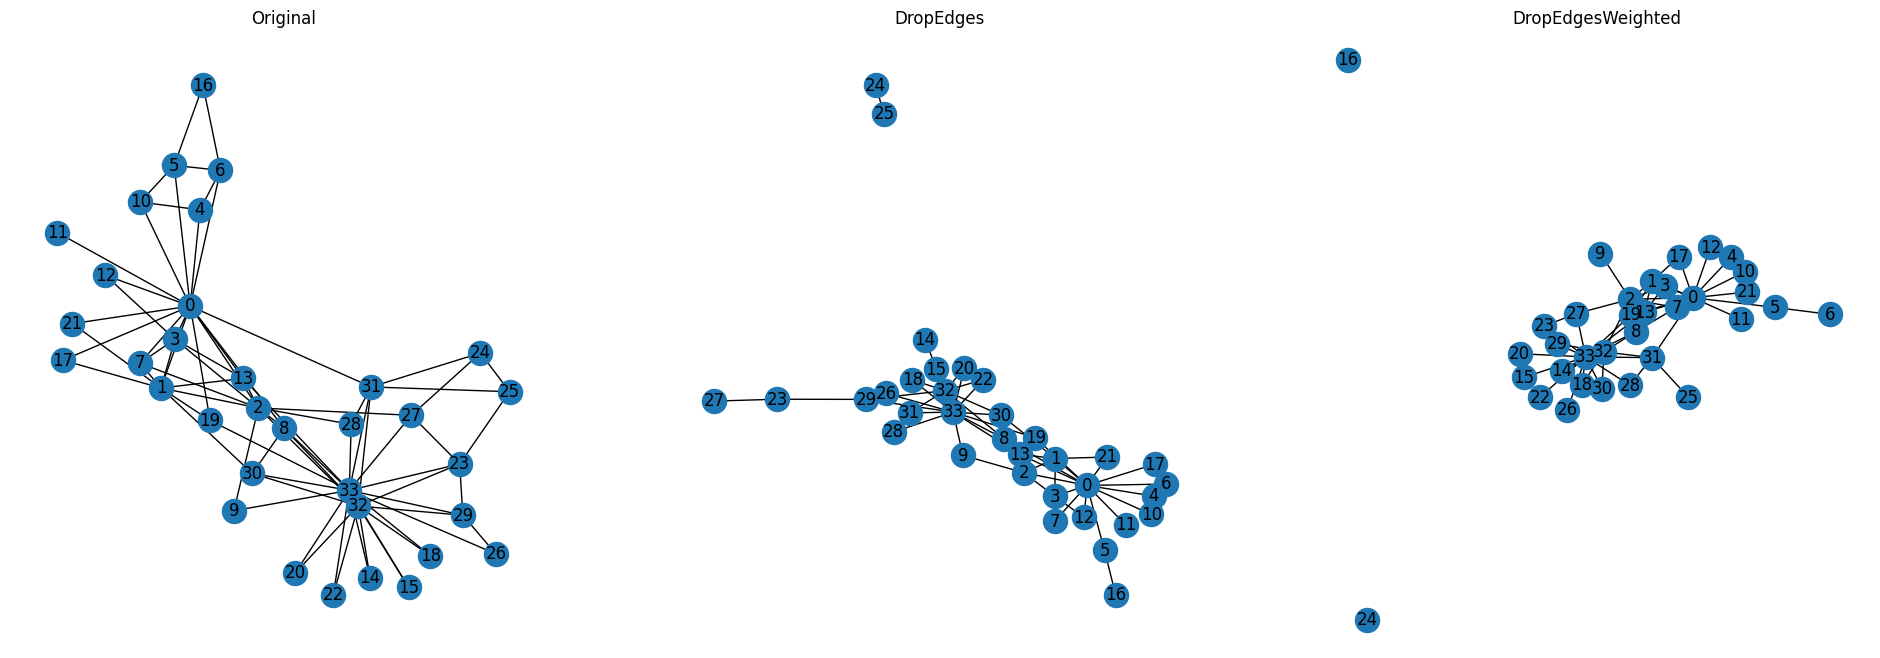

In [83]:
import matplotlib.pyplot as plt

plt.figure(figsize=(24, 8))
plt.subplot(1, 3, 1)
G = to_networkx(data, to_undirected=True)
G_dropped = to_networkx(data_dropped, to_undirected=True)
G_dropped_weighted = to_networkx(data_dropped_weighted, to_undirected=True)
nx.draw(G, with_labels=True)
plt.title('Original')
plt.subplot(1, 3, 2)
nx.draw(G_dropped, with_labels=True)
plt.title('DropEdges')
plt.subplot(1, 3, 3)
nx.draw(G_dropped_weighted, with_labels=True)
plt.title('DropEdgesWeighted')
plt.show()

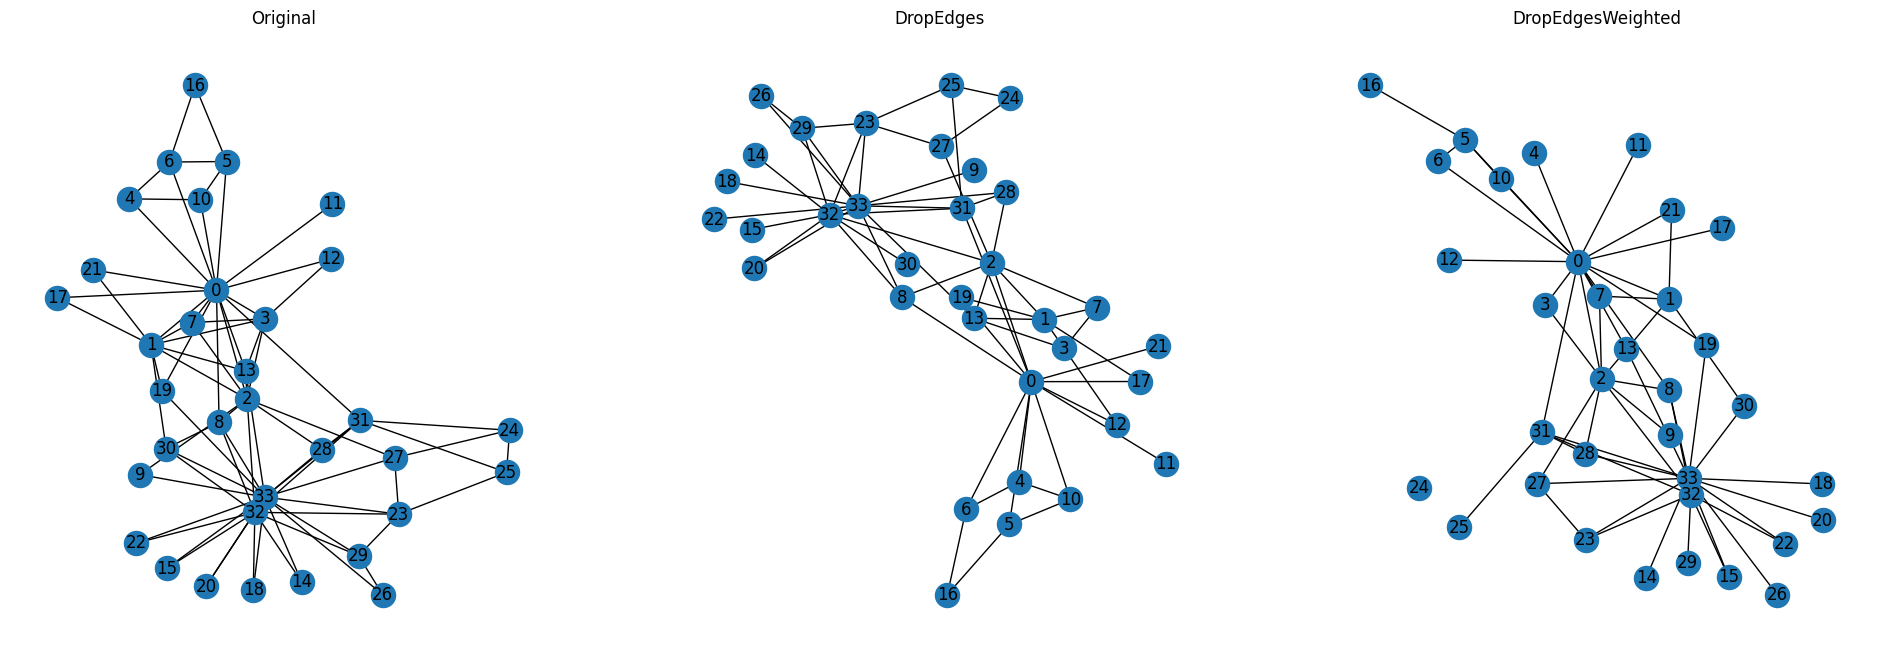

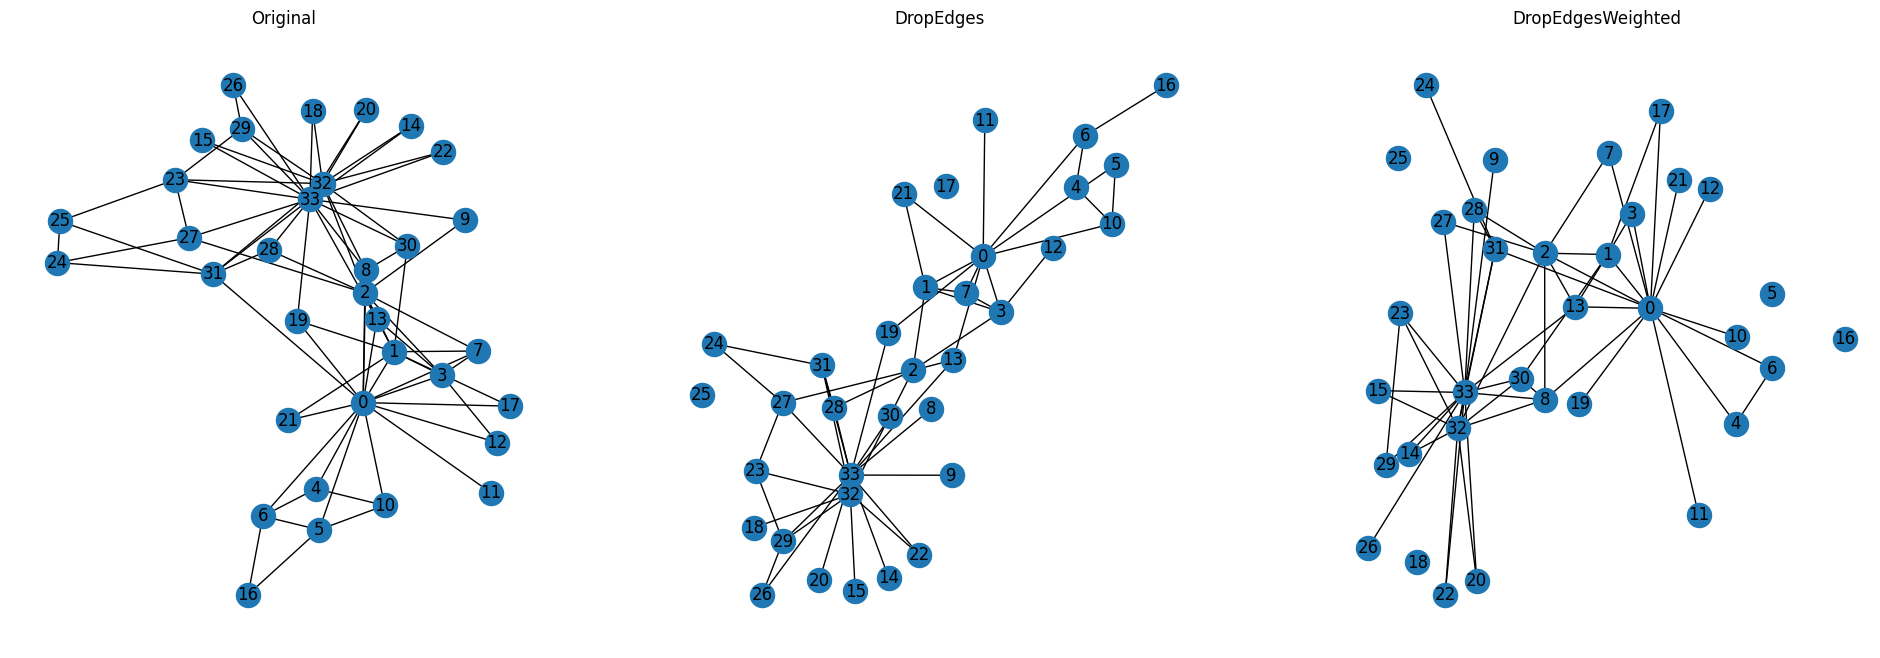

([1.0, 1.965, 2.535],
 [4.588235294117656, 3.473823529411764, 3.135882352941179],
 [0.0, 18.945, 24.69])

In [85]:
def repeat(n, plot_every=100):
    connected_components_counts = [0, 0, 0]
    average_degree = [0, 0, 0]
    edit_distance = [0, 0, 0]
    for i in range(n):
        data = KarateClub()[0]
        data.centrality = log_normalize(betweenness_centrality(to_networkx(data, to_undirected=True)))
        data_dropped = DropEdges(0.5)(deepcopy(data))
        data_dropped_weighted = DropEdgesWeighted(0.5)(deepcopy(data))
        G = to_networkx(data, to_undirected=True)
        G_dropped = to_networkx(data_dropped, to_undirected=True)
        G_dropped_weighted = to_networkx(data_dropped_weighted, to_undirected=True)
        connected_components_counts[0] += nx.number_connected_components(G)
        connected_components_counts[1] += nx.number_connected_components(G_dropped)
        connected_components_counts[2] += nx.number_connected_components(G_dropped_weighted)
        average_degree[0] += sum(dict(G.degree()).values())/len(G)
        average_degree[1] += sum(dict(G_dropped.degree()).values())/len(G_dropped)
        average_degree[2] += sum(dict(G_dropped_weighted.degree()).values())/len(G_dropped_weighted)
        edit_distance[1] += nx.graph_edit_distance(G, G_dropped)
        edit_distance[2] += nx.graph_edit_distance(G, G_dropped_weighted)

        pos=nx.spring_layout(G)
        if i % plot_every == 0:
            plt.figure(figsize=(24, 8))
            plt.subplot(1, 3, 1)
            nx.draw(G, with_labels=True, pos=nx.spring_layout(G))
            plt.title('Original')
            plt.subplot(1, 3, 2)
            nx.draw(G_dropped, with_labels=True, pos=nx.spring_layout(G))
            plt.title('DropEdges')
            plt.subplot(1, 3, 3)
            nx.draw(G_dropped_weighted, with_labels=True, pos=nx.spring_layout(G))
            plt.title('DropEdgesWeighted')
            plt.show()

    return [x/n for x in connected_components_counts], [x/n for x in average_degree], [x/n for x in edit_distance]

repeat(200)